In [28]:
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import os

## Residual connections

### Residual block where the number of filters changes

In [ ]:
inputs = keras.Input( shape=(32,32,3))

x = layers.Conv2D(filters = 32, kernel_size= 3, activation="relu")(inputs)
residual = x

x = layers.Conv2D(64,1)(residual)
x = layers.add([x, residual])

Above code throws 
ValueError: Inputs have incompatible shapes. Received shapes (30, 30, 64) and (30, 30, 32)

Reason
* adding the input back to the output of a block implies that the output should have the same shape as the input
* However, this is not the case if your block includes convolutional layers with an increased number of filters, or a max pooling layer

Solution
* use a 1 × 1 Conv2D layer with no activation to linearly project the residual to the desired output shape
* use padding= "same" in the convolution layers in your target block so as to avoid spatial downsampling due to padding, and you’d use strides in the residual projection to match any downsampling caused by a max pooling

In [ ]:
residual.shape

In [ ]:
# inputs = keras.Input( shape=(32,32,3))
# x = layers.Conv2D(filters = 32, kernel_size= 3, activation="relu")(inputs)
# residual = x
# x = layers.Conv2D(filters = 64, kernel_size= 3, activation="relu", padding= "same")(x)
# x = layers.Conv2D(64,1)(residual)
# x = layers.add([x, residual])

inputs = keras.Input(shape=(32, 32, 3)) 
x = layers.Conv2D(32, 3, activation="relu")(inputs) 
residual = x                                                     
x = layers.Conv2D(64, 3, activation="relu", 
padding="same")(x)   
residual = layers.Conv2D(64, 1)(residual)                        
x = layers.add([x, residual]) 

*  Set aside the residual. 
* This is the layer around which we create a residual connection: it 
increases the number of output filers from 32 to 64. Note that we use 
padding="same" to avoid downsampling due to padding. 
* The residual only had 32 filters, so we use a 1 × 1 Conv2D to project 
it to the correct shape. 
* Now the block output and the residual have the same shape and 
can be added. 

### Case where the target block includes a max pooling layer 

❶ Set aside the residual.  
❷ This is the block of two layers around which we create a residual 
connection: it includes a 2 × 2 max pooling layer. Note that we use
padding="same" in both the convolution layer and the max pooling 
layer to avoid downsampling due to padding.  
❸ We use strides=2 in the residual projection to match the 
downsampling created by the max pooling layer.  
❹ Now the block output and the residual have the same shape and 
can be added. 

In [ ]:
inputs = keras.Input(shape=(32, 32, 3)) 
x = layers.Conv2D(32, 3, activation="relu")(inputs) 
residual = x                                    #1
x = layers.Conv2D(64, 3, activation="relu", 
padding="same")(x)                              # 2
x = layers.MaxPooling2D(2, padding="same")(x)                   
# 3
residual = layers.Conv2D(64, 1, strides=2)(residual)            
# 4
x = layers.add([x, residual])

In [ ]:
print(residual.shape)
print(x.shape)

##  Batch normalization 

In [ ]:
x = layers.Conv2D(32, 3, activation="relu")(x) 
x = layers.BatchNormalization()(x)

How to use batch normalization: the activation comes last

❶ Note the lack of activation here.  
❷ We place the activation after the BatchNormalization layer.  

The intuitive reason for this approach is that batch normalization will 
center your inputs on zero, while your relu activation uses zero as a 
pivot for keeping or dropping activated channels: doing 
normalization before the activation maximizes the utilization of 
the relu. 

In [ ]:
x = layers.Conv2D(32, 3, use_bias = False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

## smaller version of Xception

In [ ]:
data_augmentation = keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.2)
])

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)                                      #❶
 
x = layers.Rescaling(1./255)(x)                                   # ❷
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)   # ❸
 
for size in [32, 64, 128, 256, 512]:                              # ❹
    residual = x
 
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
  
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
  
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
  
    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])
  
x = layers.GlobalAveragePooling2D()(x)                            # ❺
x = layers.Dropout(0.5)(x)                                        # ❻
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
import os , shutil, pathlib
PATH = os.path.join('D:\Abhishek x360\Coding\PythonCode\Deep Learning Chollet\dogs-vs-cats')
os.listdir(PATH)
os.chdir(PATH)
train = os.path.join(PATH, 'train','train')
test = os.path.join(PATH, 'test')
os.chdir(train)
new_base_dir = pathlib.Path("cats_vs_dogs_small")  

In [ ]:
# cwd = os.getcwd()
# train_ds = os.path.join( cwd, "train\\train\\cats_vs_dogs_small\\train")
# test_ds = os.path.join( cwd, "train\train\cats_vs_dogs_small\test")
# val_ds = os.path.join( cwd, "train\train\cats_vs_dogs_small\validation")
# train

In [ ]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

In [ ]:
for data_batch, label_batch in train_dataset:
    print( "data_batch.shape: ", data_batch.shape)
    print( "label batch shape: ", label_batch.shape)
    break

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath = "small_xception_net_with_augmentation.keras",
        save_best_only = True,
        monitor = "val_loss"
    )
]
history = model.fit(
        train_dataset,
        epochs=20,
        validation_data= validation_dataset,
        callbacks= callbacks)

##  Interpreting what convnets learn

* Visualizing intermediate convnet outputs (intermediate activations)
* Visualizing convnet filters
* Visualizing heatmaps of class activation in an image

### Visualizing intermediate activations

In [ ]:
model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")

model.summary()

Preprocessing a single image

❶ Download a test image.

❷ Open the image file and resizet.

❸ Turn the image into a float32 NumPy array of shape (180, 180,3).

❹ Add a dimension to transform the array into a “batch” of a single sample. Its shape is now (1, 180, 180, 3).

In [8]:
img_path = keras.utils.get_file(
    fname = "cat.jpg",
    origin="https://img-datasets.s3.amazonaws.com/cat.jpg")

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size= target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

img_tensor = get_img_array(img_path, target_size= (180,180))

In [ ]:
plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

Instantiating a model that returns layer activations

❶ Extract the outputs of all Conv2D and MaxPooling2D layers and 
put them in a list.   
 ❷ Save the layer names for later.

❸ Create a model that will return these outputs, given the model 
inut. ut. 

In [ ]:
layer_outputs =[]
layer_names = []
 
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)): 
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)


activation_model = keras.Model(inputs = model.input, outputs = layer_outputs)

In [ ]:
layer_names

 Using the model to compute layer activations
 *  Return a list of nine NumPy arrays: one array per layer activation. 

In [ ]:
activations = activation_model.predict(img_tensor)

In [ ]:
first_layer_activation = activations[0] 
print(first_layer_activation.shape)

In [ ]:
#visualizing all 9 channels
for i in range(8):
    layer_activation = activations[i] 
    print(layer_activation.shape)

Visualizing the fifth channel of first activation  layer
* Fifth channel of the activation of the first layer on the test 
cat picture
* total 32 channels in first activation  layer (1, 178, 178, 32)

In [ ]:
plt.matshow(first_layer_activation[0,:,:,5],
          # cmap= "binary")
            cmap="viridis")

Visualizing every channel in every intermediate activation 

* plot a complete visualization of all the activations in the 
networ 
* extract and plot every channel in each 
of the layer activation
* we stack the results in one big grid, 
with channels stacked side by sidesk

❶ Iterate over the activations (and the names of the corresponding layers).

❷ The layer activation has shape (1, size, size, n_features).

❸ Prepare an empty grid for displaying all the channels in this activation.

❹ This is a single channel (or feature).

❺ Normalize channel values within the [0, 255] range. All-zero channels are kept at zero.

❻ Place the channel matrix in the empty grid we prepared.

❼ Display the grid for the layer.

In [ ]:
images_per_row = 16 
for layer_name, layer_activation in zip(layer_names, activations):        # 1
    n_features = layer_activation.shape[-1]                                #2
    size = layer_activation.shape[1]                                       #2
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size + 1) * n_cols - 1,                      #3
                             images_per_row * (size + 1) - 1))             #3
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()#4
            if channel_image.sum() != 0:                                   #5
                channel_image -= channel_image.mean()                      #5
                channel_image /= channel_image.std()                       #5
                channel_image *= 64                                        #5
                channel_image += 128                                       #5
            channel_image = np.clip(channel_image, 0, 255).astype("uint8") #5
            display_grid[
                col * (size + 1): (col + 1) * size + col,                  #6
                row * (size + 1) : (row + 1) * size + row] = channel_image #6
    scale = 1. / size                                                      #7
    plt.figure(figsize=(scale * display_grid.shape[1],                     #7
                        scale * display_grid.shape[0]))                    #7
    plt.title(layer_name)                                                  #7
    plt.grid(False)                                                        #7
    plt.axis("off")                                                        #7
    plt.imshow(display_grid, aspect="auto", cmap="viridis")        

### Visualizing convnet filters 

Instantiating the Xception convolutional base

* The classification layers are irrelevant for this use case, so we 
don’t include the top stage of the model
* the SeparableConv2D layers here are all named 
something like block6_sepconv1, block7_sepconv2.

In [2]:
model  = keras.applications.xception.Xception(
                weights= "imagenet",
                include_top = False)



83683744/83683744 [==============================] - 10s 0us/step


 Printing the names of all convolutional layers in Xception

In [3]:
for layer in model.layers:
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
        print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d
block3_sepconv1
block3_sepconv2
conv2d_1
block4_sepconv1
block4_sepconv2
conv2d_2
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_3
block14_sepconv1
block14_sepconv2


 Creating a feature extractor model
 *  that returns the output of a specific 
laye -> —a feature extractor mode
 *   Because our model is a Functional 
API model, it is inspectable: we can query the output of one of its 
layers and reuse it in a new model. No need to copy the entir  
Xception c  odel

In [6]:
layer_name = "block3_sepconv1"

layer = model.get_layer(name = layer_name)

feature_extractor = keras.Model(inputs = model.input, outputs = layer.output)

Using the feature extractor 

In [ ]:
activation = feature_extractor(keras.applications.xception.preprocess_input(img_tensor))

“loss function”

* use our feature extractor model to define a function that returns a scalar value quantifying how much a given input image “activates”  a given filter in the layer.
* This is the “loss function” that we’ll maximize during the gradient ascent process

1. The loss function takes an image tensor and the index of the filter 
we are considering (an integer). 
2. Note that we avoid border artifacts by only involving non-border 
pixels in the loss; we discard the first two pixels along the sides of the 
activation. 
3. Return the mean of the activation values for the filter.* :

In [10]:
def compute_loss(image, filter_index):
    activation = feature_extractor(image)          # model(x)
    fileter_activation = activation[:, 2:-2,2:-2, filter_index]
    return tf.reduce_mean(fileter_activation)                             

Loss maximization via stochastic gradient ascent

1. Explicitly watch the image tensor, since it isn’t a TensorFlow 
Variableas (only Variables are automatically watched in   gradient 
tape
2.  Compute the loss scalar, indicating how much the current image 
activates the filter
 3. Compute the gradients of the loss with respect to the image.
4. Apply the “gradient normalization trick.
5. Move the image a little bit in a direction that activates our target 
filter more strongly
6. Return the updated image so we can run the step function in a 
loo. p
 
). a 
loop.

In [13]:
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, filter_index)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return image

Function to generate filter visualizations

1.  Number of gradient ascent steps to apply
2.  Amplitude of a single step
3.  Initialize an image tensor with random values (the Xception model 
expects input values in the [0, 1] range, so here we pick a range
centered on 0.
4.  Repeatedly update the values of the image tensor so as to 
maximize our loss function    5)

In [16]:
img_width = 200  
img_height = 200  

def generate_filter_pattern(filter_index):
    iterations = 30   #1
    learning_rate = 10   #2
    image = tf.random.uniform(minval= 0.4,               #3
                              maxval= 0.6, 
                              shape = (1, img_width, img_height, 3))

    for i in range(iterations):      #4
        image = gradient_ascent_step(image, filter_index, learning_rate)
    return image[0].numpy()

Utility function to convert a tensor into a valid image

1. Normalize image values within the [0, 255] range.
2. Center crop to avoid border artifacts.

In [40]:
def deprocess_image(image):
    image -= image.mean()                            #1
    image /= image.std()                            #1
    image  *= 64                                     #1
    image  += 128                                    #1
    image = np.clip(image, 0,255).astype("uint8")      #1
    image = image[25:-25, 25:-25, :]                    #2
    return image

Pattern that the second channel in  layer block3_sepconv1 responds to maximally 

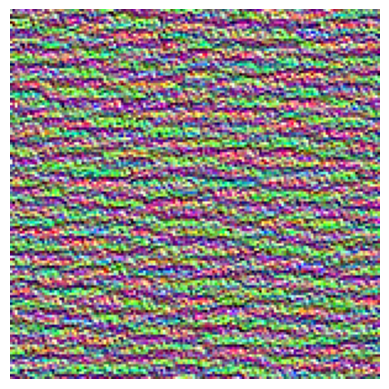

In [26]:
plt.axis("off") 
plt.imshow(deprecoess_image(generate_filter_pattern(filter_index=2)))

#### Generating a grid of all filter response patterns in a layer 

In [43]:
path = os.path.join(os.getcwd(),"layer_images")
path

'D:\\Abhishek x360\\Coding\\PythonCode\\Deep Learning Chollet\\layer_images'

In [45]:

all_images = []
for filter_index in range(64):
    print(f"Processing filter {filter_index}")
    image = deprocess_image(
        generate_filter_pattern(filter_index)
    )
    all_images.append(image)

margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n):
    for j in range(n):
        image = all_images[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = image

keras.utils.save_img(
    f"filters_for_layer_{layer_name}.png", stitched_filters)

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr